#### ✅ Import libs

In [1]:
import argparse
import re
import warnings
from typing import List, Tuple

import joblib
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report,recall_score,precision_score,f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split , cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


from Custom_func.Functions import *

warnings.filterwarnings("ignore", category=UserWarning)

# Ensure NLTK data is available
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### ✅ Data Understanding 

#### ✅ Load the Data

In [2]:
# Step 1: Load the dataset
# - Read the CSV file into a pandas DataFrame
# - Drop unnecessary index columns ('Unnamed: 0.1' and 'Unnamed: 0') that may have been created during CSV export
# - After this step, we can proceed to check data types, duplicates, and missing values.
df = pd.read_csv("3) Sentiment dataset.csv")

In [3]:
df.head(3)

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15


#### ✅ Drop idx Columns

In [4]:
cols = ['Unnamed: 0.1','Unnamed: 0']
df.drop(columns=cols,inplace=True)

#### ✅ Check info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Text       732 non-null    object 
 1   Sentiment  732 non-null    object 
 2   Timestamp  732 non-null    object 
 3   User       732 non-null    object 
 4   Platform   732 non-null    object 
 5   Hashtags   732 non-null    object 
 6   Retweets   732 non-null    float64
 7   Likes      732 non-null    float64
 8   Country    732 non-null    object 
 9   Year       732 non-null    int64  
 10  Month      732 non-null    int64  
 11  Day        732 non-null    int64  
 12  Hour       732 non-null    int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 74.5+ KB


#### ✅ Fix Time Data type

In [6]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

#### ✅ Check Dupl

In [7]:
# from info there are no nulls  
#let's check dup
df.duplicated().sum()

np.int64(20)

In [8]:
# Step 2: Explore basic statistics of numerical columns
# - Use .describe() to get summary statistics (count, mean, std, min, quartiles, max)
# - This helps us understand the distribution and spread of numerical features
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Timestamp,732,2020-12-08 21:37:38.196721408,2010-05-15 15:30:00,2019-03-08 17:27:30,2021-09-20 14:30:00,2023-02-26 11:48:45,2023-10-22 20:45:00,NaN
Retweets,732.0,21.508197,5.0,17.75,22.0,25.0,40.0,7.061286
Likes,732.0,42.901639,10.0,34.75,43.0,50.0,80.0,14.089848
Year,732.0,2020.471311,2010.0,2019.0,2021.0,2023.0,2023.0,2.802285
Month,732.0,6.122951,1.0,3.0,6.0,9.0,12.0,3.411763
Day,732.0,15.497268,1.0,9.0,15.0,22.0,31.0,8.474553
Hour,732.0,15.521858,0.0,13.0,16.0,19.0,23.0,4.113414


### ✅ EDA

#### ✅ Target Analysis 

In [9]:
# Step 3: Explore the target variable "Sentiment"
# - Check how many unique sentiment classes exist using .nunique()
# - Use .describe() to see frequency counts and most common class
df[['Sentiment']].describe().T

,count,unique,top,freq
Sentiment,732,279,Positive,44


In [10]:
# Step 4: Check the most frequent sentiment values
# - Use value_counts() to see how many times each sentiment appears
# - Display only the top 10 most common sentiment classes
df['Sentiment'].value_counts().reset_index().head(10)

,Sentiment,count
0,Positive,44
1,Joy,42
2,Excitement,32
3,Happy,14
4,Neutral,14
5,Contentment,14
6,Gratitude,9
7,Hopeful,9
8,Sad,9
9,Curiosity,8


In [11]:
# let's see unique list 
df['Sentiment'].unique()

array([' Positive  ', ' Negative  ', ' Neutral   ', ' Anger        ',
       ' Fear         ', ' Sadness      ', ' Disgust      ',
       ' Happiness    ', ' Joy          ', ' Love         ',
       ' Amusement    ', ' Enjoyment    ', ' Admiration   ',
       ' Affection    ', ' Awe          ', ' Disappointed ',
       ' Surprise     ', ' Acceptance   ', ' Adoration    ',
       ' Anticipation ', ' Bitter       ', ' Calmness     ',
       ' Confusion    ', ' Excitement   ', ' Kind         ',
       ' Pride        ', ' Shame        ', ' Confusion ', ' Excitement ',
       ' Shame ', ' Elation       ', ' Euphoria      ', ' Contentment   ',
       ' Serenity      ', ' Gratitude     ', ' Hope          ',
       ' Empowerment   ', ' Compassion    ', ' Tenderness    ',
       ' Arousal       ', ' Enthusiasm    ', ' Fulfillment  ',
       ' Reverence     ', ' Compassion', ' Fulfillment   ', ' Reverence ',
       ' Elation   ', ' Despair         ', ' Grief           ',
       ' Loneliness     

#### ✅ Create New Target 

In [12]:
# Step 5: Create a new target variable
# - Apply a custom function (defined separately in the project files) 
#   to transform or re-map the original "Sentiment" column
# - This helps simplify or standardize sentiment categories for modeling

In [13]:
# Step 6: Clean and transform the Sentiment column
# - Remove extra spaces from sentiment labels (strip out whitespace)
df['Sentiment'] = df['Sentiment'].str.replace(' ',"")

# Step 7: Create a new binary column "Spam"
# - Apply map_emotion() to map sentiment values into categories
# - Then apply check_spam() to flag certain categories as spam  or ham
df['Spam'] = df['Sentiment'].apply(map_emotion).apply(check_spam)

In [14]:
df['Spam'].unique()

array(['ham', 'spam'], dtype=object)

In [15]:
df['Spam'].value_counts()

Spam
ham     652
spam     80
Name: count, dtype: int64

#### ✅ Analyze text using world cloud 

🔝 Frequent Keywords in Spam:
[('new', 14), ('excitement', 9), ('surprise', 7), ('school', 7), ('trying', 5), ('night', 5), ('ancient', 5), ('exploring', 5), ('adventure', 5), ('club', 5), ('attending', 4), ('upcoming', 4), ('attempting', 4), ('recipe', 3), ('experiencing', 3), ('breathtaking', 3), ('building', 3), ('beauty', 3), ('book', 3), ('weekend', 3)]

🧊 Frequent Keywords in Ham:
[('life', 34), ('new', 29), ('like', 25), ('dreams', 25), ('feeling', 24), ('heart', 24), ('day', 23), ('laughter', 23), ('joy', 22), ('world', 20), ('art', 20), ('journey', 20), ('every', 19), ('garden', 17), ('beauty', 17), ('challenges', 17), ('night', 17), ('lost', 17), ('sky', 17), ('concert', 16)]


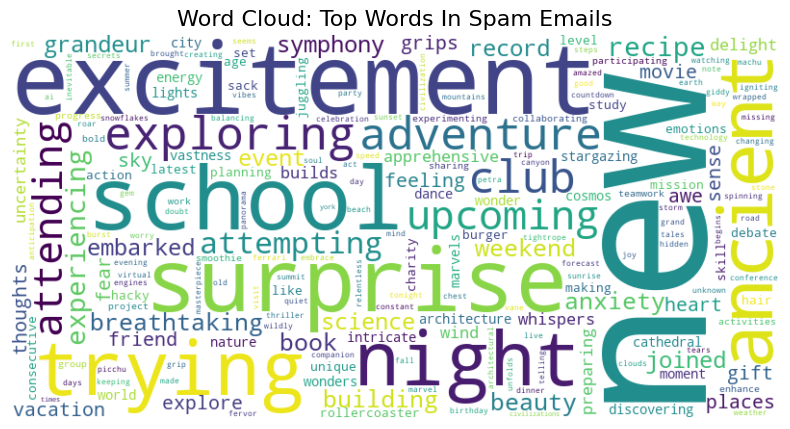

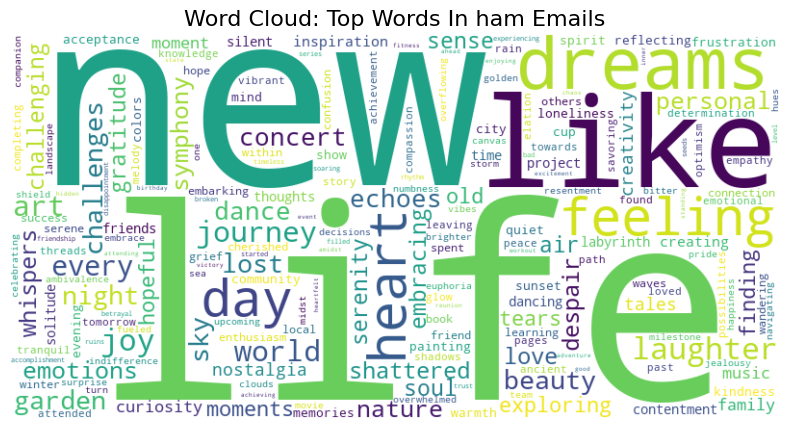

In [16]:
# Seprate to 2 df spam or ham

spamdf = df[df['Spam']=='spam'].copy()
hamdf = df[df['Spam']=='ham'].copy()


top_spam_words = Counter([
    word 
    for text in spamdf['Text']  # Loop over product titles
    for word in clean_text(text)            # Clean and split each title into words
])

# Step 5.2: Count word frequencies in low-selling product titles
top_ham_words = Counter([
    word 
    for text in hamdf['Text']
    for word in clean_text(text)
])

# Step 6: Display the top 20 most frequent keywords in both groups
print("🔝 Frequent Keywords in Spam:")
print(top_spam_words.most_common(20))

print("\n🧊 Frequent Keywords in Ham:")
print(top_ham_words.most_common(20))

# Plot both
plot_wordcloud(top_spam_words, "Word Cloud: Top Words In Spam Emails")
plot_wordcloud(top_ham_words, "Word Cloud: Top Words In ham Emails")

### ✅ Preprocessing 

#### ✅ Clean Text

In [17]:
# Step 8: Text preprocessing function
# - Convert text to lowercase
# - Remove URLs, mentions (@username), hashtags, special characters, and numbers
# - Tokenize text into words
# - Remove stopwords and apply lemmatization
# - Return cleaned text as a single string
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs, mentions, hashtags, special chars, numbers
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text,preserve_line="C:/Users/ahmed/AppData/Roaming/nltk_data/tokenizers")
    # Remove stopwords & lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)


#### ✅ TF-IDF 

In [18]:
# Step 10: Feature Extraction using TF-IDF
# We will use two different TF-IDF vectorizers:
# 1) word_tfidf: 
word_tfidf = TfidfVectorizer(
        tokenizer=preprocess_text,    # custom tokenizer with lemmatization
        ngram_range=(1, 2),           # unigrams + bigrams
        min_df=2,
        max_df=0.90,
        max_features=50000,
        strip_accents="unicode",
        lowercase=True,
    )

# 2) char_tfidf:
char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),           # char trigrams to 5-grams
    min_df=2,
    max_features=50000,
    lowercase=True,
    strip_accents="unicode",
)

#### ✅ Column Transformer

In [19]:
# Step 11: Combine features using ColumnTransformer
# - Apply both word-level and character-level TF-IDF vectorizers to the "Text" column
# - This allows the model to learn from both word patterns and subword/character patterns
# - remainder="drop" ensures we only keep these features
# - sparse_threshold=1.0 ensures the output remains sparse (efficient for large text data)

features = ColumnTransformer(
        transformers=[
            ("word_tfidf", word_tfidf, "Text"),
            ("char_tfidf", char_tfidf, "Text"),
        ],
        remainder="drop",
        sparse_threshold=1.0, 
)

### ✅ Model Testing

#### ✅ Models List

In [20]:
# Step 12: Define candidate models for classification
# - We'll experiment with a mix of linear, tree-based, and distance-based algorithms
# - Each model will be evaluated later using cross-validation or a pipeline
models = [
    ('LR',LogisticRegression()),
    ("RF" , RandomForestClassifier()),
    ("KNN",KNeighborsClassifier()),
    ("CART",DecisionTreeClassifier()),
    ('LSVC',LinearSVC())
]

#### ✅ Train & Test Split

In [21]:
# Step 13: Split data into features (X) and target (y)
# - X: the input text column ("Text")
# - y: the binary target ("Spam"), mapped as {spam=1, ham=0}
x = df[['Text']] 
y = df['Spam'].map({'spam':1,"ham":0})


# Step 14: Train-test split
# - 80% training, 20% testing
# - random_state=42 ensures reproducibility
# - stratify=y keeps the same spam/ham ratio in both train and test sets
x_train , x_test , y_train , y_test = train_test_split(x,y,train_size=0.8, random_state=42,stratify=y)

#### ✅ For Loop test

In [22]:
# Step 15: Train and evaluate models using a pipeline + cross-validation
# - Each model is wrapped in a pipeline with:
#   1) Feature extraction (word & char TF-IDF via ColumnTransformer)
#   2) Dimensionality reduction (TruncatedSVD for handling sparse high-dimensional TF-IDF)
#   3) Classifier (LR, RF, KNN, CART, LSVC)
# - We use cross_validate to compute both train and test accuracy scores
# - Return mean results across folds
for model in models:
    print("Testing For:",model[0])
    steps = [
        ("features", features),
        ("svd", TruncatedSVD(random_state=42)),
        (model) 
    ]
    pipeline = Pipeline(steps=steps)
    res = cross_validate(pipeline , x , y , scoring='accuracy',return_train_score=True )
    print("Train Accuracy:", res['train_score'].mean())
    print("Test Accuracy:", res['test_score'].mean())
    print('_'*50)

Testing For: LR
Train Accuracy: 0.8907103060004085
Test Accuracy: 0.8907091603764794
__________________________________________________
Testing For: RF
Train Accuracy: 0.9996581196581197
Test Accuracy: 0.8770571242195508
__________________________________________________
Testing For: KNN
Train Accuracy: 0.8944651556255652
Test Accuracy: 0.8743267169881651
__________________________________________________
Testing For: CART
Train Accuracy: 1.0
Test Accuracy: 0.8019755847544496
__________________________________________________
Testing For: LSVC
Train Accuracy: 0.8907103060004085
Test Accuracy: 0.8907091603764794
__________________________________________________


### ✅ Model Evaluation with LR

In [23]:
# Step 16: Define evaluation function
# - Prints detailed classification metrics for test predictions
# - Includes precision, recall, F1-score, and accuracy
# - Uses classification_report for class-wise performance
# - By default, sklearn metrics like precision/recall/F1 need an "average" argument 
#   if it's a binary or multi-class classification (macro, weighted, etc.)
def evaluate_and_report(y_true, y_pred) -> None:
    print("\n---> Set Accuracy Score <----")
    print(accuracy_score(y_true,y_pred))
    print("\n---> Set Recall Score <----")
    print(recall_score(y_true,y_pred))
    print("\n---> Set Precision Score <----")
    print(precision_score(y_true,y_pred))
    print("\n---> Set F1 Score <----")
    print(f1_score(y_true,y_pred))

In [24]:
%%time 
print("Grid Parameter set...")
param_grid = {
    "svd__n_components": [100, 200, 300, 500],
    "LR__C": [0.01, 0.1, 1, 10, 100],
    "LR__penalty": ["l1", "l2"],
    "LR__solver": ["liblinear", "saga"],  # supports l1 and l2
    "LR__max_iter": [500, 1000, 2000]
}

print("Creating Final steps for Pipeline...")
final_steps = [
    ("features", features),
    ("svd", TruncatedSVD(random_state=42)),
    (models[0]) 
]

print("Set Model with Pipeline...")
lr = Pipeline(final_steps)



print("Model Fitting...")
lr.fit(x_train,y_train)
print("|---> Fitted Successfully <---|")

Grid Parameter set...
Creating Final steps for Pipeline...
Set Model with Pipeline...
Model Fitting...
|---> Fitted Successfully <---|
CPU times: total: 344 ms
Wall time: 260 ms


In [26]:
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print("==== Train Evalution Matrix ====")
evaluate_and_report(y_true=y_train,y_pred=y_train_pred)
print("==== Test Evalution Matrix ====")
evaluate_and_report(y_true=y_test,y_pred=y_test_pred)

==== Train Evalution Matrix ====

---> Set Accuracy Score <----
0.8905982905982905

---> Set Recall Score <----
0.0

---> Set Precision Score <----
0.0

---> Set F1 Score <----
0.0
==== Test Evalution Matrix ====

---> Set Accuracy Score <----
0.891156462585034

---> Set Recall Score <----
0.0

---> Set Precision Score <----
0.0

---> Set F1 Score <----
0.0
